In [1]:
import numpy as np
import matplotlib.pyplot as plt
#plt.style.use(['science','notebook'])
%matplotlib notebook
from scipy.ndimage import convolve, generate_binary_structure

Laplaces Equation:

$$\boxed{\nabla^2 V=0 \hspace{20mm} V_{\Omega_1}(\vec{r}) = \phi(x,y,z) \hspace{5mm} \frac{\partial V_{\Omega_2}}{\partial n} = 0}$$

* Blue region below represents $\Omega_1$. These are places of **fixed potential**, and represent **conductors**. 
* Grey region below represents $\Omega_2$. These represent regions of **fixed charge** (in this case, $0$) and represent **insulators**.

<p align="center">
  <img src="../images/vid31p1.png" alt="drawing" width="400" align="center"/>
</p>

We are in 3D space, so this means

$$\frac{\partial^2 V}{\partial x^2}+\frac{\partial^2 V}{\partial y^2} + \frac{\partial^2 V}{\partial z^2}=0$$

This equation can be discretely approximated as

$$\frac{V_{i+1,j,k} - 2V_{i,j,k} + V_{i-1,j,k}}{(\Delta x)^2} + \frac{V_{i,j+1,k} - 2V_{i,j,k} + V_{i,j-1,k}}{(\Delta y)^2}+ \frac{V_{i,j,k+1} - 2V_{i,j,k} + V_{i,j,k-1}}{(\Delta z)^2} = 0 $$

Noting that $ \Delta x = \Delta y$ in our array, we can solve for $V(x_i, y_j)$ yielding

$$\boxed{V_{i,j,k}= \frac{1}{6}\left(V_{i+1,j,k}+V_{i-1,j,k}+ V_{i,j+1,k}+ V_{i,j-1,k}+ V_{i,j,k+1}+ V_{i+1,j,k-1} \right)}$$

The expression above is a **property** of the **true** solution. We don't know the true solution. An idea, however, is to repeatedly set

$$V_{i,j,k} \to \frac{1}{6}\left(V_{i+1,j,k}+V_{i-1,j,k}+ V_{i,j+1,k}+ V_{i,j-1,k}+ V_{i,j,k+1}+ V_{i+1,j,k-1} \right)$$

and hope that $V$ will eventually converge to the true solution. It turns out that it can be mathematically proven that this is the case. In order to do this, we need a good initial guess for $V_{i,j,k}$.

The problem we will solve today is

<p align="center">
  <img src="../images/vid31p2.png" alt="drawing" width="300" align="center"/>
</p>

This is a 2D picture, but we are solving it in 3 dimensions. It represents two parallel plates held at constant potential (**conductors**) surrounded by an **insulating** box with a constant charge of 0. The idea is that it gives the **true potential of finite area parallel plates** at all points in space. The conducting box provides **a good approximation of the infinite boundary condition that $V \to 0$ as $\vec{r} \to \infty$.

First lets come up with our grid of potential. Rather than solving $\nabla^2 V =0 $, we will solve $\nabla^2 (V/V_0) = 0$ to keep the problem dimensionless.

* **If** $V$ satisfies $\nabla^2 (V/V_0) = 0$ **then** $V$ satisfies $\nabla^2 V = 0$, so this is alright


Set $V/V_0 = 0.5$ everywhere. We use a 100x100x100 grid.

In [3]:
N = 100
grid = np.zeros((N,N,N))+0.5


In [126]:
c=np.zeros((N,N,N))
c1=np.copy(c)

In [5]:
grad=np.linspace(1,0,223)
grad1=np.repeat([np.repeat([grad],5,axis=0)],5,axis=0)
grad2=np.repeat([np.repeat([grad],5,axis=0).transpose()],5,axis=0)

Set the location of the parallel plates equal to $V/V_0 = 1$ and $V/V_0 =0$. Then get the location of these parallel plates in boolean array format.

In [124]:
grid[40:45,40:45,10:50] = np.sort(grad[0:40])
grid[40:45,45:75,10:15] = (grad2[:,41:71,:])


grid[40:45,75:80,10:90]=grad[72:152]


grid[40:45,45:75,85:90] = np.sort(grad2[:,153:183,:],1)
grid[40:45,40:45,51:90] = np.sort(grad[184:223])



In [130]:
###Conductividad
c[43,43:77,12] =1
c[43,77,12:88]= 1
c[43,43:77,87] = 1
c[43,43,12:87]= 1
c[43,43,49:51]= 0


#
c1[40:45,40:45,10:50] = 1
c1[40:45,45:75,10:15] = 1


c1[40:45,75:80,10:90]=1


c1[40:45,45:75,85:90] = 1
c1[40:45,40:45,51:90] = 1

<IPython.core.display.Javascript object>


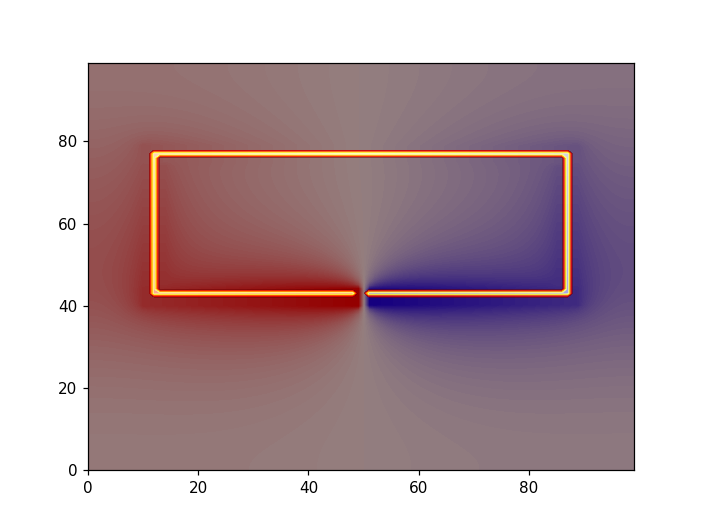

In [131]:
plt.figure()
plt.contourf(grid[43],levels=100,cmap='bwr')
plt.contourf(c[43],levels=10,cmap='hot',alpha=0.5)

Use a meshgrid to come up with an initial guess for the potential

* Potential goes from $V/V_0=1$ at the left to $V/V_0=0$ at the right in the diagram above. This is a good first order approximation

In [10]:
yv, xv, zv = np.meshgrid(np.arange(N),np.arange(N),np.arange(N))
#grid = 1-zv/100

Now, as we know, we need to apply

$$V_{i,j,k} \to \frac{1}{6}\left(V_{i+1,j,k}+V_{i-1,j,k}+ V_{i,j+1,k}+ V_{i,j-1,k}+ V_{i,j,k+1}+ V_{i+1,j,k-1} \right)$$

over and over and we will eventually get the true potential at all places in space. It turns out that this can be represented by a convolution. Think about the 2D analog $V_{i,j} \to \frac{1}{4}\left(V_{i+1,j}+V_{i-1,j}+ V_{i,j+1}+ V_{i,j-1} \right)$. Consider the example below.

<p align="center">
  <img src="../images/vid31p3.png" alt="drawing" width="300" align="center"/>
</p>

* The red box represents $V_{i,j}$. This value, initially equal to 5, will be updated in the next iteration
* The purple boxes represent $V_{i+1,j}, V_{i-1,j}, V_{i,j+1}, V_{i,j-1}$
* Thus in the next iteration $V_{i,j} \to \frac{1}{4}(1+2+6+7) = 4$

This occurs for all pixels in the array. It follows that this operation is equal to a convolution with the matrix

$$\begin{bmatrix} 0 & 1/4 & 0\\ 1/4 & 0 & 1/4 \\ 0 & 1/4 & 0\\ \end{bmatrix}$$

In 3D, the analog is:

In [11]:
kern = generate_binary_structure(3,1).astype(float)/6
kern[1,1,1] = 0
kern

array([[[0.        , 0.        , 0.        ],
        [0.        , 0.16666667, 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.        , 0.16666667, 0.        ],
        [0.16666667, 0.        , 0.16666667],
        [0.        , 0.16666667, 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.16666667, 0.        ],
        [0.        , 0.        , 0.        ]]])

The following function is used to set $\partial V / \partial n = 0$ at all the boundaries. At the $x=0$ boundary, for example, it sets $V_{0,j,k} = V_{1,j,k}$ in $x$, which means that $\partial V / \partial x \approx \Delta V / \Delta x =  0$ since $\Delta V = 0 $. This is done for all 6 boundaries.

In [12]:
def neumann(a):
    a[0,:,:] = a[1,:,:]; a[-1,:,:] = a[-2,:,:]
    a[:,0,:] = a[:,1,:]; a[:,-1,:] = a[:,-2,:]
    a[:,:,0] = a[:,:,1]; a[:,:,-1] = a[:,:,-2]
    return a

This function implements the updating of the grid by applying a sequence of convolutions. We also keep track of the error between consecutive iterations using the `err` list.

In [132]:
err = []
iters = 2000
for i in range(iters):
    grid_updated = convolve(grid,kern, mode='constant')
    # Boundary conditions (neumann)
    grid_updated = neumann(grid_updated)
    #Boundary conditions (dirchlett)
    grid_updated[40:45,40:45,10:50] = np.sort(grad[0:40])
    grid_updated[40:45,45:75,10:15] = (grad2[:,41:71,:])
    
    
    grid_updated[40:45,75:80,10:90]=grad[72:152]
    
    
    grid_updated[40:45,45:75,85:90] = np.sort(grad2[:,153:183,:],1)
    grid_updated[40:45,40:45,51:90] = np.sort(grad[184:223])
    # See what error is between consecutive arrays
    err.append(np.mean((grid-grid_updated)**2))
    grid = grid_updated

Plot the potential at a given slice

In [133]:
E1=np.gradient(-grid)
E=np.array([E1[0],E1[1],E1[2]])
ME=np.linalg.norm(E,axis=0)

In [134]:
mask1=np.where(c>=1)

B=np.zeros((N,N,N))
#R=np.zeros((n,n))
for i in range(0,len(mask1[0])):
    EE=np.array([(E/ME)[0][mask1][i],(E/ME)[1][mask1][i],(E/ME)[2][mask1][i]])
    X=xv-xv[mask1][i]
    Y=yv-yv[mask1][i]
    Z=zv-zv[mask1][i]
    r=np.array([X,Y,Z])
    cr=np.array([EE[1]*r[2]-EE[2]*r[1],EE[2]*r[0]-EE[0]*r[2],EE[0]*r[1]-EE[1]*r[0]])
    B=B+cr/(r[0]**2+r[1]**2+r[2]**2)**(3/2)

MB=np.linalg.norm(B,axis=0)

C:\Users\Arif\AppData\Local\Temp\ipykernel_28804\2751780536.py:6: RuntimeWarning: invalid value encountered in divide
  EE=np.array([(E/ME)[0][mask1][i],(E/ME)[1][mask1][i],(E/ME)[2][mask1][i]])
C:\Users\Arif\AppData\Local\Temp\ipykernel_28804\2751780536.py:12: RuntimeWarning: invalid value encountered in divide
  B=B+cr/(r[0]**2+r[1]**2+r[2]**2)**(3/2)


In [139]:
S=np.cross(E,B,axis=0)
MS=np.linalg.norm(S,axis=0)

In [140]:
slc = 42

<IPython.core.display.Javascript object>


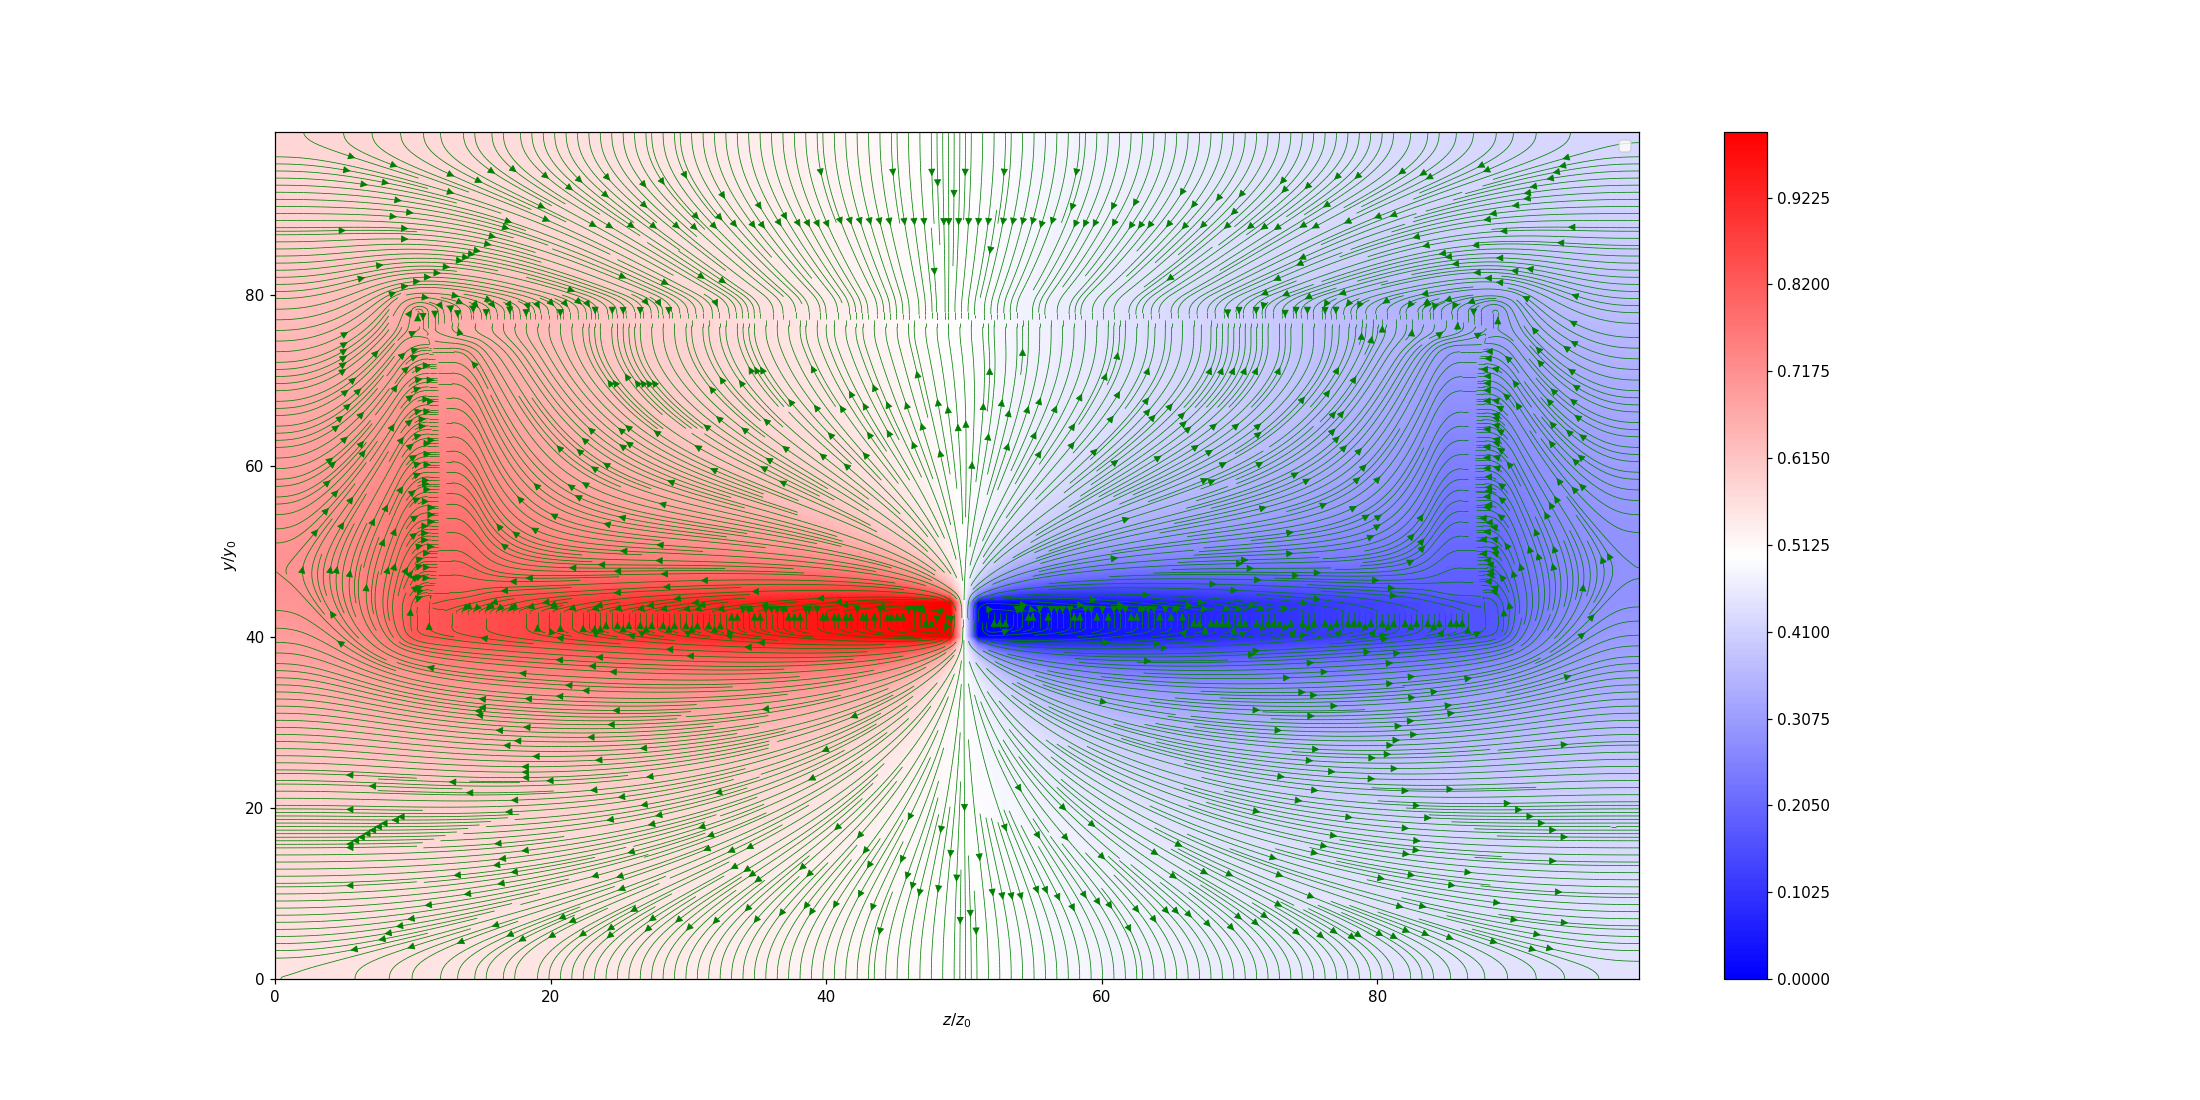

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [158]:
plt.figure(figsize=(20,10))
CS = plt.contourf(zv[slc], yv[slc], grid[slc], levels=400,cmap='bwr')
plt.colorbar(CS)
#plt.streamplot(zv[slc],yv[slc],(E)[2][slc],(E)[1][slc],linewidth=1,density=6,color='black',cmap='seismic')
#plt.quiver(zv[slc],yv[slc],(E/ME)[2][slc],(E/ME)[1][slc],color='black')
##########Campo magnetico
#plt.streamplot(zv[slc],yv[slc],B[2][slc],B[1][slc],density=7,linewidth=1/2,color='purple')
#plt.quiver(zv[slc],yv[slc],(B/MB)[2][slc],(B/MB)[1][slc],color='purple')

###Poynting
plt.streamplot(zv[slc],yv[slc],S[2][slc],S[1][slc],density=8,linewidth=1/2,color='green')
#plt.quiver(zv[slc],yv[slc],(S/MS)[2][slc],(S/MS)[1][slc],color='green')
#plt.clabel(CS, CS.levels, inline=True, fontsize=6)
plt.xlabel('$z/z_0$')
plt.ylabel('$y/y_0$')
#plt.axvline(0.2, ymin=0.3, ymax=0.7, color='r')
#plt.axvline(0.8, ymin=0.3, ymax=0.7, color='g')
plt.legend()
plt.show()

In [163]:
mask2=[42]#np.linspace(0,99,10,dtype=int)
mask2

[42]

<IPython.core.display.Javascript object>


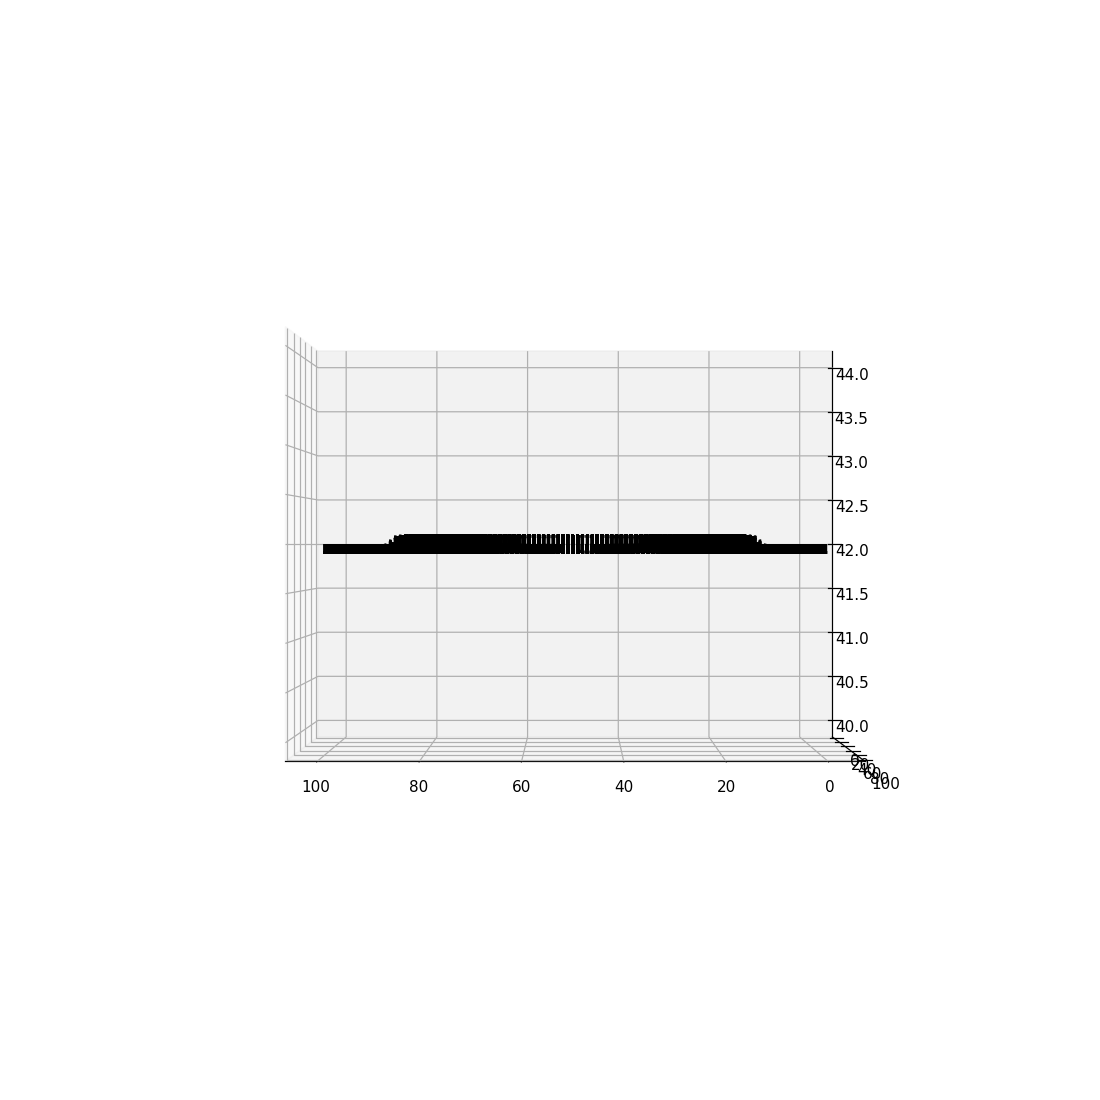

In [164]:
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
plt.quiver(zv[mask2],yv[mask2],xv[mask2],(B[2]/MB)[mask2],(B[1]/MB)[mask2],(B[0]/MB)[mask2],color='black',length=1/10)
ax.view_init(elev=0, azim=90)

Plot the error:

* RMSE = "root mean squared error" $=\sqrt{\left<(V_{\text{new}}-V_{\text{old}})^2 \right>}$ where "new" is the updated array for the given iteration and "old" is the old array.

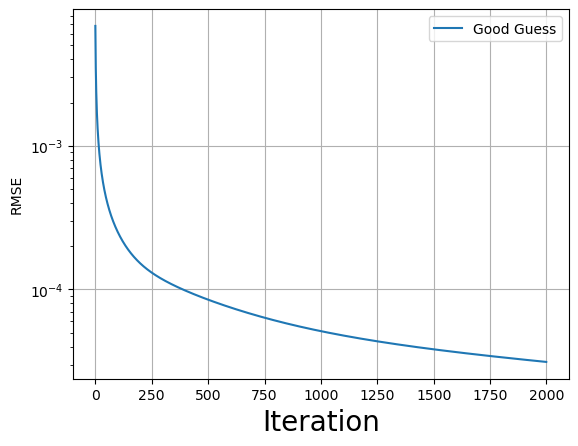

In [10]:
plt.semilogy(np.sqrt(np.array(err)), label='Good Guess')
plt.legend()
plt.xlabel('Iteration', fontsize=20)
plt.ylabel(r'RMSE')
plt.grid()